## Tool Calling with Agentic AI - LangGraph

In this notebook we will learn how to use Tool Calling with Agentic AI in order to solve different problems.

Tool-calling agents expand the capabilities of an LLM by allowing it to interact with external systems. This approach empowers agents to dynamically solve problems by utilizing tools, accessing memory, and planning multi-step actions.

Tool calling agents enable:

1. Multi-Step Decision Making: The LLM can orchestrate a sequence of decisions to achieve complex objectives.
2. Tool Access: The LLM can select and use various tools as needed to interact with external systems and APIs.

This architecture allows for more dynamic and flexible behaviors, enabling agents to solve complex tasks by leveraging external resources efficiently.

### Requirements and Imports

Import necessary libraries, including `langchain_core`, `langgraph`, and `langchain_community`.

In [1]:
!pip install autogen-agentchat~=0.2 autogen psutil --quiet
# !pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client==0.12.3 langgraph langchain_experimental yfinance
!pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client langgraph langchain_experimental openai --quiet


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Agentic AI libraries
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage, AIMessage
import requests
import re
import os

### Tool for checking externally the app

Define the tools that the agent will use, such as a simulated web search for weather and an analysis tool for technical questions.

First you need to deploy the middleware app in OpenShift that will give us access to the Weather Tool Retriever API.

Deploy the weather application with the following:

```bash
kubectl apply -k agents/weather-app/gitops 
```

In [3]:
# Search tool
@tool
def search(query: str):
    """Get weather information from weather-app middleware."""

    # Extract city name using Regex
    match = re.search(r"\b(?:weather in|forecast for)\s+([a-zA-Z\s]+)\b", query, re.IGNORECASE)
    # Default to the full query if no match
    city = match.group(1).strip() if match else query.strip()
    # Define the weather app URL for the API call
    api_url = f"{WEATHER_API_BASE_URL}/weather/?city_name={city}"

    # Make the API call to the weather-app
    try:
        response = requests.get(api_url)
        response.raise_for_status()
        weather_data = response.json()

        # Extract relevant weather information from the JSON response
        temperature = weather_data.get("temperature", "N/A")
        cloud_cover = weather_data.get("cloud_cover", "N/A")
        humidity = weather_data.get("relative_humidity", "N/A")
        wind_speed = weather_data.get("wind_speed", "N/A")

        # Format the output message
        weather_info = (f"The current weather in {city} is as follows:\n"
                        f"Temperature: {temperature}°C\n"
                        f"Cloud Cover: {cloud_cover}%\n"
                        f"Humidity: {humidity}%\n"
                        f"Wind Speed: {wind_speed} km/h")
        return weather_info

    except requests.exceptions.RequestException as e:
        return f"Error fetching weather data: {str(e)}"

# Analyze tool
@tool
def analyze(query: str):
    """Simulate an analysis tool for technical questions."""
    return f"Analyzing the concept of {query}... The analysis is complete."

In [4]:
# Weather App API URL
# WEATHER_API_BASE_URL = "http://weather-app:8000"
WEATHER_API_BASE_URL = "http://weather-app.llm-deploy.svc.cluster.local:8000"

### Initialize LLM
Set up the Large Language Model (LLM) using the VLLM interface. This model will process inputs and optionally invoke tools.

In [5]:
# LLM Inference Server URL
# INFERENCE_SERVER_URL = "http://localhost:8080"
# MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"
# API_KEY= "alanliuxiang"

INFERENCE_SERVER_URL = "http://localhost:8000"
MODEL_NAME = "ibm-granite/granite-3.0-8b-instruct"
API_KEY= "alanliuxiang"

# INFERENCE_SERVER_URL = "https://api.feidaapi.com"
# MODEL_NAME = "gpt-4"
# API_KEY= "sk-TsoMJYTiW1Ya1AatboGdUGXEdCOAWeCeIbvUCkNMonrCHoQ7"

# LLM definition
llm = ChatOpenAI(
    openai_api_key=API_KEY,
    openai_api_base= f"{INFERENCE_SERVER_URL}/v1",
    model_name=MODEL_NAME,
    top_p=0.92,
    temperature=0.01,
    max_tokens=512,
    presence_penalty=1.03,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)

Create a prompt template that the LLM will use to generate responses. This template guides the LLM to use tools when necessary.

In [6]:
# Define the combined prompt template
template = """<s>[INST]<<SYS>>
You are a helpful, respectful, and honest assistant. Always be as helpful as possible, while being safe.
You will be asked a question, to which you must give an answer.
Your answer should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content.
Please ensure that your responses are socially unbiased and positive in nature.
If a question does not make any sense, or is not factually coherent, explain why instead of answering something incorrect.
If the question requires real-time information or specific technical analysis that you cannot provide directly, respond by indicating you will use a tool to retrieve the information and then use the tool to provide the accurate data.
<</SYS>>

### QUESTION:
{input}

### ANSWER:
If this question requires real-time information or analysis, I will retrieve the data for you using a reliable source or tool.
[/INST]
"""
PROMPT = PromptTemplate(input_variables=["input"], template=template)

### Define Conditional Logic for Workflow Continuation
Create a function to determine whether the workflow should continue to the tools node or stop based on the LLM's output.

In [7]:
# List to track tool usage
tools_used_log = []

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

### Create the Function to Call the LLM
Define a function that sends the formatted prompt to the LLM and decides whether to invoke any tools based on the query.


In [8]:
def call_model(state: MessagesState):
    messages = state['messages']
    user_query = messages[-1].content.lower()

    # Check if the query is about weather
    if "weather" in user_query or "forecast" in user_query:
        # Invoke the weather tool directly
        tool_result = search.invoke(user_query)
        if isinstance(tool_result, str):
            ai_message = AIMessage(content=tool_result)
        else:
            ai_message = AIMessage(content="Error fetching weather data.")
        tools_used_log.append("search")  # Log the tool usage
    else:
        # Process non-weather queries through the LLM
        formatted_prompt = PROMPT.format(input=user_query)
        response = llm.invoke(formatted_prompt)

        # Create AIMessage based on LLM's response
        if "analyze" in user_query or "technical" in user_query:
            tool_result = analyze.invoke(user_query)
            final_response = f"{tool_result}. If you need further information, feel free to ask."
            ai_message = AIMessage(content=final_response)
            tools_used_log.append("analyze")  # Log the tool usage
        else:
            ai_message = AIMessage(content=response)

    return {"messages": [ai_message]}


### Agentic AI Workflow Logic
First, we need to set the entry point for graph execution - agent node.

Then we define one normal and one conditional edge. Conditional edge means that the destination depends on the contents of the graph's state (MessageState). In our case, the destination is not known until the agent (LLM) decides.

* Conditional edge: after the agent is called, we should either:
  * Run tools if the agent said to take an action, OR
  * Finish (respond to the user) if the agent did not ask to run tools
* Normal edge: after the tools are invoked, the graph should always return to the agent to decide what to do next

In [9]:
# Define the workflow
tools = [search, analyze]
tool_node = ToolNode(tools)

# we initialize graph (StateGraph) by passing state schema (in our case MessagesState)
workflow = StateGraph(MessagesState)

# The agent node: responsible for deciding what (if any) actions to take.
workflow.add_node("agent", call_model)

# The tools node that invokes tools: if the agent decides to take an action, this node will then execute that action.
workflow.add_node("tools", tool_node)

# Set the entry point of the workflow to the "agent" node
workflow.add_edge(START, "agent")

# Add conditional edges based on the LLM's response
workflow.add_conditional_edges("agent", should_continue)

# Add a normal edge from the "tools" node back to the "agent" node
workflow.add_edge("tools", 'agent')

### Compile the graph
* When we compile the graph, we turn it into a LangChain Runnable, which automatically enables calling .invoke(), .stream() and .batch() with your inputs
* We can also optionally pass checkpointer object for persisting state between graph runs, and enabling memory, human-in-the-loop workflows, time travel and more. In our case we use MemorySaver - a simple in-memory checkpointer

In [10]:
# Initialize memory
# Use `MemorySaver` to allow the workflow to persist state between executions, maintaining context.
checkpointer = MemorySaver()

In [11]:
# Compile the workflow into a runnable app
app = workflow.compile(checkpointer=checkpointer)

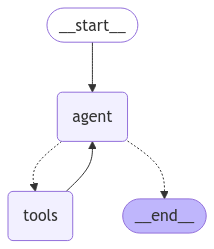

In [12]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("Graph visualization failed. Ensure you have the required dependencies.")

### Invoke the Workflow with an Example Input and Check the Tool Usage (if any)
* Run the workflow with a sample input
* Print which tools were used during the session, if any.


1. LangGraph adds the input message to the internal state, then passes the state to the entrypoint node, "agent".
2. The "agent" node executes, invoking the chat model.
3. The chat model returns an AIMessage. LangGraph adds this to the state.
4. Graph cycles the following steps until there are no more tool_calls on AIMessage:
    * If AIMessage has tool_calls, "tools" node executes
    * The "agent" node executes again and returns AIMessage
5. Execution progresses to the special END value and outputs the final state. And as a result, we get a list of all our chat messages as output.

In [13]:
# Invoke the workflow with an example input
input_prompt = "What is the weather in Dolomites?"

final_state = app.invoke(
    {"messages": [HumanMessage(content=input_prompt)]},
    config={"configurable": {"thread_id": 42}}
)

# Output the last response
print(final_state["messages"][-1].content)

# Inspect which tools were used during this session
if not tools_used_log:
    print("No tools were used.")
else:
    for tool_name in tools_used_log:
        print(f"Tool used: {tool_name}")

The current weather in dolomites is as follows:
Temperature: -2.700000047683716°C
Cloud Cover: 100.0%
Humidity: 98.0%
Wind Speed: 2.595996856689453 km/h
Tool used: search


In [14]:
# Initialize tools_used_log before invoking the workflow
tools_used_log = []  # Reset the log to ensure it's fresh for each session

# Invoke the workflow with an example input
input_prompt = "Analyze why Dolomites is better than Catalan Pyrenees for hiking"

final_state = app.invoke(
    {"messages": [HumanMessage(content=input_prompt)]},
    config={"configurable": {"thread_id": 42}}
)

# Output the last response
print(final_state["messages"][-1].content)

# Inspect which tools were used during this session
if not tools_used_log:
    print("No tools were used.")
else:
    for tool_name in tools_used_log:
        print(f"Tool used: {tool_name}")

The Dolomites and the Catalan Pyrenees both offer unique hiking experiences, and the preference for one over the other can be subjective, depending on individual preferences. However, there are a few reasons why some might prefer hiking in the Dolomites:

1. **Diversity of Trails**: The Dolomites offer a wide range of trails suitable for all levels of hikers, from beginners to experienced mountaineers. 

2. **Scenic Beauty**: The Dolomites are renowned for their stunning landscapes, featuring towering peaks, deep valleys, and beautiful alpine meadows. This dramatic scenery can make for a more visually appealing hike.

3. **Cultural Experience**: Hiking in the Dolomites also offers the opportunity to experience the unique culture of the region, which is a blend of Italian and Austrian influences.

4. **Well-Marked Trails and Refugios**: The Dolomites have an extensive network of well-marked trails and mountain huts (refugios), making it easier for hikers to plan their routes and find ac

In [15]:
# Initialize tools_used_log before invoking the workflow
tools_used_log = []  # Reset the log to ensure it's fresh for each session

# Invoke the workflow with an example input
input_prompt = "What gear should I bring to hike mountains like Dolomites?"

final_state = app.invoke(
    {"messages": [HumanMessage(content=input_prompt)]},
    config={"configurable": {"thread_id": 42}}
)

# Output the last response
print(final_state["messages"][-1].content)

# Inspect which tools were used during this session
if not tools_used_log:
    print("No tools were used.")
else:
    for tool_name in tools_used_log:
        print(f"Tool used: {tool_name}")

When planning a hike in mountainous regions like the Dolomites, it's important to be well-prepared. Here are some essential items you should consider:

1. Hiking Boots: A good pair of hiking boots is crucial for any mountain trek. They should be waterproof, durable, and comfortable.

2. Clothing: Dress in layers so you can adjust your clothing to the weather conditions. Include moisture-wicking base layers, an insulating mid-layer, and a waterproof outer layer. Don't forget a hat and gloves.

3. Backpack: A sturdy backpack to carry all your gear is necessary. Make sure it has enough space for all your essentials and is comfortable to wear for long periods.

4. Food and Water: Always bring more than you think you'll need. Consider bringing a water filter or purification tablets as well.

5. Navigation Tools: A map and compass are essential, even if you plan to use a GPS device. 

6. First Aid Kit: This should include bandages, antiseptic wipes, tweezers, medical tape, pain relievers, an

ValidationError: 21 validation errors for AIMessage
content.str
  Input should be a valid string [type=string_type, input_value=AIMessage(content="When p...ee-9ae8-d4ae13c57fb3-0'), input_type=AIMessage]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].0.str
  Input should be a valid string [type=string_type, input_value=('content', "When plannin...ns before setting out."), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].0.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('content', "When plannin...ns before setting out."), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].1.str
  Input should be a valid string [type=string_type, input_value=('additional_kwargs', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].1.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('additional_kwargs', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].2.str
  Input should be a valid string [type=string_type, input_value=('response_metadata', {'f... 'model_name': 'gpt-4'}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].2.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('response_metadata', {'f... 'model_name': 'gpt-4'}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].3.str
  Input should be a valid string [type=string_type, input_value=('type', 'ai'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].3.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('type', 'ai'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].4.str
  Input should be a valid string [type=string_type, input_value=('name', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].4.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('name', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].5.str
  Input should be a valid string [type=string_type, input_value=('id', 'run-5b14eeef-f643...ee-9ae8-d4ae13c57fb3-0'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].5.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('id', 'run-5b14eeef-f643...ee-9ae8-d4ae13c57fb3-0'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].6.str
  Input should be a valid string [type=string_type, input_value=('example', False), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].6.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('example', False), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].7.str
  Input should be a valid string [type=string_type, input_value=('tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].7.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].8.str
  Input should be a valid string [type=string_type, input_value=('invalid_tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].8.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('invalid_tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].9.str
  Input should be a valid string [type=string_type, input_value=('usage_metadata', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].9.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('usage_metadata', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type

In [ ]:
# Initialize tools_used_log before invoking the workflow
tools_used_log = []  # Reset the log to ensure it's fresh for each session

# Invoke the workflow with an example input
input_prompt = "What is Agentic AI?"

final_state = app.invoke(
    {"messages": [HumanMessage(content=input_prompt)]},
    config={"configurable": {"thread_id": 42}}
)

# Output the last response
print(final_state["messages"][-1].content)

# Inspect which tools were used during this session
if not tools_used_log:
    print("No tools were used.")
else:
    for tool_name in tools_used_log:
        print(f"Tool used: {tool_name}")